# Feature ideas

Building upon trial outcome predictiont task, we add the following historical adverse events features

- `avg_condition_historical_adverse_event`: for this condition, what is historical adverse event count? 
- `avg_facility_historical_adverse_event`: for this facility,  what is historical adverse event count? 
- `avg_sponsor_historical_adverse_event`: for this sponsor, what is historical adverse event count? 
- `avg_intervention_historical_adverse_event`: for this intervention,  what is historical adverse event count? 



In [7]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from relbench.datasets import get_dataset

from tqdm import tqdm 
from pandarallel import pandarallel
pandarallel.initialize(progress_bar=False, nb_workers = 10)

def get_adverse_rate(transaction, column, nct_id, timestamp, reported_event_totals):
    nct_history = transaction[(transaction[column].isin(transaction[transaction.nct_id == nct_id][column].values)) & (transaction.date < timestamp)].nct_id.unique()
    event_temp = reported_event_totals[reported_event_totals.nct_id.isin(nct_history)]
    event_temp = event_temp[(event_temp.event_type == 'serious') | (event_temp.event_type == 'deaths')]
    event_temp = event_temp[~event_temp.subjects_affected.isnull()]
    nct2event = event_temp.groupby('nct_id').subjects_affected.sum()

    if len(nct2event) == 0:
        return 0
    else:
        return sum(nct2event)/len(nct2event)

def get_success_rate(transaction, column, nct_id, timestamp, outcome_analyses):
    nct_history = transaction[(transaction[column].isin(transaction[transaction.nct_id == nct_id][column].values)) & (transaction.date < timestamp)].nct_id.unique()
    outcome_temp = outcome_analyses[outcome_analyses.nct_id.isin(nct_history)]
    outcome_temp = outcome_temp[(outcome_temp.p_value_modifier.isnull()) | (outcome_temp.p_value_modifier != '>')]
    outcome_temp = outcome_temp[(outcome_temp.p_value >= 0) & (outcome_temp.p_value <= 1) & (outcome_temp.outcome_type == 'Primary')]
    nct2p = outcome_temp.groupby('nct_id').p_value.min()
    if len(nct2p) == 0:
        return 0
    else:
        return sum(nct2p<= 0.05)/len(nct2p)

def get_features(train_df):
    dataset = get_dataset(name='rel-trial', process=False)
    task = dataset.get_task('rel-trial-outcome', process=True)
    tables = dataset.get_db().table_dict

    interventions_studies = tables['interventions_studies'].df
    conditions_studies = tables['conditions_studies'].df
    sponsors_studies = tables['sponsors_studies'].df
    facilities_studies = tables['facilities_studies'].df
    studies = tables['studies'].df
    designs = tables['designs'].df
    eligibilities = tables['eligibilities'].df
    sponsors = tables['sponsors'].df

    outcomes = tables['outcomes'].df
    facilities = tables['facilities'].df
    outcome_analyses = tables['outcome_analyses'].df
    outcome_analyses = outcome_analyses.merge(outcomes[['id', 'outcome_type']], left_on='outcome_id', right_on = 'id')
    reported_event_totals = tables["reported_event_totals"].df
    eligibilities['minimum_age'] = eligibilities['minimum_age'].apply(lambda x: int(x.split('Years')[0]) if (x is not None) and ('Years' in x) else -1)
    eligibilities['maximum_age'] = eligibilities['maximum_age'].apply(lambda x: int(x.split('Years')[0]) if (x is not None) and ('Years' in x) else -1)
    
    train_studies = train_df.merge(studies, how='left')

    train_studies['is_observational'] = train_studies.study_type.apply(lambda x: 1 if x in ['Observational', 'Observational [Patient Registry]'] else 0)
    train_studies['is_interventional'] = train_studies.study_type.apply(lambda x: 1 if x in ['Interventional'] else 0)
    train_studies['is_expanded_access'] = train_studies.study_type.apply(lambda x: 1 if x in ['Expanded Access'] else 0)

    train_studies['is_phase_1'] = train_studies.phase.apply(lambda x: 1 if (x is not None) and ('Phase 1' in x) else 0)
    train_studies['is_phase_2'] = train_studies.phase.apply(lambda x: 1 if (x is not None) and ('Phase 2' in x) else 0)
    train_studies['is_phase_3'] = train_studies.phase.apply(lambda x: 1 if (x is not None) and ('Phase 3' in x) else 0)
    train_studies['is_phase_4'] = train_studies.phase.apply(lambda x: 1 if (x is not None) and ('Phase 4' in x) else 0)

    train_studies = train_studies[['nct_id', 'is_observational', 'is_interventional', 'is_expanded_access', 'is_phase_1', 'is_phase_2', 'is_phase_3', 'is_phase_4', 
                'enrollment', 'number_of_arms', 'number_of_groups', 'has_dmc', 'is_fda_regulated_drug', 'is_fda_regulated_device', 'is_unapproved_device', 
                'is_ppsd', 'is_us_export', 'biospec_retention', 'plan_to_share_ipd']]

    train_df = train_df.merge(train_studies, how='left')
    train_design = train_df.merge(designs)
    train_design['is_randomized'] = train_design.allocation.apply(lambda x: 1 if x == 'Randomized' else 0)
    train_design['is_parallel_assignment'] = train_design.intervention_model.apply(lambda x: 1 if x == 'Parallel Assignment' else 0)
    train_design['is_single_group_assignment'] = train_design.intervention_model.apply(lambda x: 1 if x == 'Single Group Assignment' else 0)
    train_design['is_crossover_assignment'] = train_design.intervention_model.apply(lambda x: 1 if x == 'Crossover Assignment' else 0)
    train_design['is_factorial_assignment'] = train_design.intervention_model.apply(lambda x: 1 if x == 'Factorial Assignment' else 0)
    train_design['is_sequential_assignment'] = train_design.intervention_model.apply(lambda x: 1 if x == 'Sequential Assignment' else 0)

    train_design['is_single_masking'] = train_design.masking.apply(lambda x: 1 if x == 'Single' else 0)
    train_design['is_double_masking'] = train_design.masking.apply(lambda x: 1 if x == 'Double' else 0)
    train_design['is_triple_masking'] = train_design.masking.apply(lambda x: 1 if x == 'Triple' else 0)
    train_design['is_quadruple_masking'] = train_design.masking.apply(lambda x: 1 if x == 'Quadruple' else 0)
    train_design['is_no_masking'] = train_design.masking.apply(lambda x: 1 if x == 'None (Open Label)' else 0)

    train_design = train_design[['nct_id', 'is_randomized', 'is_parallel_assignment', 'is_single_group_assignment', 
    'is_crossover_assignment', 'is_factorial_assignment', 'is_sequential_assignment',
    'is_single_masking', 'is_double_masking', 'is_triple_masking', 'is_quadruple_masking', 'is_no_masking', 'primary_purpose', 
    'subject_masked', 'caregiver_masked', 'investigator_masked', 'outcomes_assessor_masked']]

    train_df = train_df.merge(train_design, how='left')

    train_eligibility = train_df.merge(eligibilities)
    train_eligibility['is_non_probability_sample'] = train_eligibility['sampling_method'].apply(lambda x: 1 if x == 'Non-Probability Sample' else 0)
    train_eligibility['is_female_only'] = train_eligibility['gender'].apply(lambda x: 1 if x == 'Female' else 0)
    train_eligibility['is_male_only'] = train_eligibility['gender'].apply(lambda x: 1 if x == 'Male' else 0)
    train_eligibility['accept_healthy_volunteer'] = train_eligibility['healthy_volunteers'].apply(lambda x: 1 if x == 'Accepts Healthy Volunteers' else 0)
    train_eligibility['is_min_age_ge_60'] = train_eligibility['minimum_age'].apply(lambda x: 1 if x >= 60 else 0)
    train_eligibility['is_max_age_le_20'] = train_eligibility['maximum_age'].apply(lambda x: 1 if x <= 20 else 0)
    train_eligibility = train_eligibility[['nct_id', 'is_non_probability_sample', 'is_female_only', 'is_male_only', 'accept_healthy_volunteer', 'is_min_age_ge_60']]

    train_df = train_df.merge(train_eligibility)

    train_df['num_history_intervention'] = train_df.parallel_apply(lambda x: interventions_studies[(interventions_studies.intervention_id.isin(interventions_studies[interventions_studies.nct_id == x.nct_id].intervention_id.values)) & (interventions_studies.date < x.timestamp)].groupby('intervention_id').nct_id.agg(len).mean(), axis = 1)
    train_df['num_history_condition'] = train_df.parallel_apply(lambda x: conditions_studies[(conditions_studies.condition_id.isin(conditions_studies[conditions_studies.nct_id == x.nct_id].condition_id.values)) & (conditions_studies.date < x.timestamp)].groupby('condition_id').nct_id.agg(len).mean(), axis = 1)
    train_df['num_history_sponsor'] = train_df.parallel_apply(lambda x: sponsors_studies[(sponsors_studies.sponsor_id.isin(sponsors_studies[sponsors_studies.nct_id == x.nct_id].sponsor_id.values)) & (sponsors_studies.date < x.timestamp)].groupby('sponsor_id').nct_id.agg(len).mean(), axis = 1)
    train_df['num_history_facility'] = train_df.parallel_apply(lambda x: facilities_studies[(facilities_studies.facility_id.isin(facilities_studies[facilities_studies.nct_id == x.nct_id].facility_id.values)) & (facilities_studies.date < x.timestamp)].groupby('facility_id').nct_id.agg(len).mean(), axis = 1)
    train_df.fillna(0, inplace=True)

    # Calculate derived features for temporal_studies
    eligibilities = tables['eligibilities'].df
    studies = tables['studies'].df
    outcomes = tables['outcomes'].df
    facilities = tables['facilities'].df
    outcome_analyses = tables['outcome_analyses'].df
    outcome_analyses = outcome_analyses.merge(outcomes[['id', 'outcome_type']], left_on='outcome_id', right_on = 'id')

    # Age range
    eligibilities['age_range'] = eligibilities['maximum_age'] - eligibilities['minimum_age']

    # Number of words in eligibility criteria
    eligibilities['num_of_words_eligibility_criteria'] = eligibilities['criteria'].apply(lambda x: len(str(x).split()) if pd.notnull(x) else 0)

    # Number of words in trial title and description
    studies['num_of_words_trial_title'] = studies['brief_title'].apply(lambda x: len(str(x).split()) if pd.notnull(x) else 0)
    studies['num_of_words_trial_description'] = studies['official_title'].apply(lambda x: len(str(x).split()) if pd.notnull(x) else 0)

    # Number of outcomes
    outcomes_counts = outcomes.groupby('nct_id').size().reset_index(name='num_outcomes')

    # In US
    facilities['in_us'] = facilities['country'].apply(lambda x: 1 if x in ['US', 'United States'] else 0)
    nct_id2in_us = facilities.merge(facilities_studies, on='facility_id').groupby('nct_id').in_us.max().reset_index()

    train_df['history_success_rate_facility'] = train_df.parallel_apply(lambda x: get_success_rate(facilities_studies, 'facility_id', x.nct_id, x.timestamp, outcome_analyses), axis = 1)
    train_df['history_success_rate_sponsor'] = train_df.parallel_apply(lambda x: get_success_rate(sponsors_studies, 'sponsor_id', x.nct_id, x.timestamp, outcome_analyses), axis = 1)
    train_df['history_success_rate_condition'] = train_df.parallel_apply(lambda x: get_success_rate(conditions_studies, 'condition_id', x.nct_id, x.timestamp, outcome_analyses), axis = 1)
    train_df['history_success_rate_intervention'] = train_df.parallel_apply(lambda x: get_success_rate(interventions_studies, 'intervention_id', x.nct_id, x.timestamp, outcome_analyses), axis = 1)

    train_df['history_adverse_event_facility'] = train_df.parallel_apply(lambda x: get_adverse_rate(facilities_studies, 'facility_id', x.nct_id, x.timestamp, reported_event_totals), axis = 1)
    train_df['history_adverse_event_sponsor'] = train_df.parallel_apply(lambda x: get_adverse_rate(sponsors_studies, 'sponsor_id', x.nct_id, x.timestamp, reported_event_totals), axis = 1)
    train_df['history_adverse_event_condition'] = train_df.parallel_apply(lambda x: get_adverse_rate(conditions_studies, 'condition_id', x.nct_id, x.timestamp, reported_event_totals), axis = 1)
    train_df['history_adverse_event_intervention'] = train_df.parallel_apply(lambda x: get_adverse_rate(interventions_studies, 'intervention_id', x.nct_id, x.timestamp, reported_event_totals), axis = 1)

    # Merge derived features
    derived_features = train_df

    derived_features = derived_features.merge(eligibilities[['nct_id', 'age_range', 'num_of_words_eligibility_criteria']], on='nct_id', how='left')
    derived_features = derived_features.merge(studies[['nct_id', 'num_of_words_trial_title', 'num_of_words_trial_description']], on='nct_id', how='left')
    derived_features = derived_features.merge(outcomes_counts, on='nct_id', how='left')
    derived_features.fillna(0, inplace=True)

    # Check if facilities are in US
    derived_features = derived_features.merge(nct_id2in_us, how='left')
    return derived_features

INFO: Pandarallel will run on 10 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [8]:
dataset = get_dataset(name='rel-trial', process=False)
task = dataset.get_task('rel-trial-adverse', process=True)

val_df = task.val_table.df
val_df = get_features(val_df)

loading Database object from /afs/cs.stanford.edu/u/kexinh/.cache/relbench/rel-trial/db...
done in 5.20 seconds.
loading Database object from /afs/cs.stanford.edu/u/kexinh/.cache/relbench/rel-trial/db...
done in 5.25 seconds.


/tmp/user/21201/ipykernel_1869640/2423341819.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  eligibilities['minimum_age'] = eligibilities['minimum_age'].apply(lambda x: int(x.split('Years')[0]) if (x is not None) and ('Years' in x) else -1)
/tmp/user/21201/ipykernel_1869640/2423341819.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  eligibilities['maximum_age'] = eligibilities['maximum_age'].apply(lambda x: int(x.split('Years')[0]) if (x is not None) and ('Years' in x) else -1)
/tmp/user/21201/ipyk

In [9]:
len(val_df)

3596

In [12]:
dataset = get_dataset(name='rel-trial', process=False)
task = dataset.get_task('rel-trial-adverse', process=True)
train_df = task.get_table("train").df
train_df = get_features(train_df)

val_df = task.val_table.df
val_df = get_features(val_df)

from torch_frame import TaskType, stype
from torch_frame.gbdt import LightGBM, XGBoost
from torch_frame.data import Dataset
from torch_frame.typing import Metric
from torch_frame.utils import infer_df_stype

col_to_stype = infer_df_stype(train_df)
col_to_stype

DROP_COLS = [
    # drop identifier cols
    'nct_id',
    'timestamp',
]
for c in DROP_COLS:
    del col_to_stype[c]

train_dset = Dataset(
    train_df.drop(DROP_COLS, axis=1),
    col_to_stype=col_to_stype,
    target_col='num_of_adverse_events'
).materialize()

val_tf = train_dset.convert_to_tensor_frame(val_df.drop(DROP_COLS, axis=1))
tune_metric = Metric.MAE
print(train_dset.tensor_frame.num_cols, train_dset.tensor_frame.num_rows)

gbdt = LightGBM(TaskType.REGRESSION, metric=tune_metric)
gbdt.tune(tf_train=train_dset.tensor_frame, tf_val=val_tf, num_trials=10)

gbdt.save('adverse_lightgbm.json')

loading Database object from /afs/cs.stanford.edu/u/kexinh/.cache/relbench/rel-trial/db...
done in 5.21 seconds.
loading Database object from /afs/cs.stanford.edu/u/kexinh/.cache/relbench/rel-trial/db...
done in 5.34 seconds.


/tmp/user/21201/ipykernel_1869640/2423341819.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  eligibilities['minimum_age'] = eligibilities['minimum_age'].apply(lambda x: int(x.split('Years')[0]) if (x is not None) and ('Years' in x) else -1)
/tmp/user/21201/ipykernel_1869640/2423341819.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  eligibilities['maximum_age'] = eligibilities['maximum_age'].apply(lambda x: int(x.split('Years')[0]) if (x is not None) and ('Years' in x) else -1)
/tmp/user/21201/ipyk

loading Database object from /afs/cs.stanford.edu/u/kexinh/.cache/relbench/rel-trial/db...
done in 5.27 seconds.


/tmp/user/21201/ipykernel_1869640/2423341819.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  eligibilities['minimum_age'] = eligibilities['minimum_age'].apply(lambda x: int(x.split('Years')[0]) if (x is not None) and ('Years' in x) else -1)
/tmp/user/21201/ipykernel_1869640/2423341819.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  eligibilities['maximum_age'] = eligibilities['maximum_age'].apply(lambda x: int(x.split('Years')[0]) if (x is not None) and ('Years' in x) else -1)
/tmp/user/21201/ipyk

57 43335
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN


[I 2024-06-01 14:30:01,603] Trial 0 finished with value: 45.609893512215876 and parameters: {'max_depth': 5, 'learning_rate': 0.04740173995629244, 'num_leaves': 636, 'subsample': 0.3010323914618284, 'colsample_bytree': 0.16830497501093108, 'lambda_l1': 7.695272137693797, 'lambda_l2': 7.036013557756245, 'min_data_in_leaf': 71}. Best is trial 0 with value: 45.609893512215876.


[2000]	valid_0's l1: 45.6106
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN


[LightGBM] [Fatal] Reducing `min_data_in_leaf` with `feature_pre_filter=true` may cause unexpected behaviour for features that were pre-filtered by the larger `min_data_in_leaf`.
You need to set `feature_pre_filter=false` to dynamically change the `min_data_in_leaf`.
[LightGBM] [Fatal] Reducing `min_data_in_leaf` with `feature_pre_filter=true` may cause unexpected behaviour for features that were pre-filtered by the larger `min_data_in_leaf`.
You need to set `feature_pre_filter=false` to dynamically change the `min_data_in_leaf`.
[I 2024-06-01 14:32:45,363] Trial 1 finished with value: 42.33442064900239 and parameters: {'max_depth': 7, 'learning_rate': 0.004984578064292042, 'num_leaves': 217, 'subsample': 0.981733493883814, 'colsample_bytree': 0.6204197334110119, 'lambda_l1': 1.3200277204518557e-07, 'lambda_l2': 0.34374479266439983, 'min_data_in_leaf': 30}. Best is trial 1 with value: 42.33442064900239.


[2000]	valid_0's l1: 42.3344


[LightGBM] [Fatal] Reducing `min_data_in_leaf` with `feature_pre_filter=true` may cause unexpected behaviour for features that were pre-filtered by the larger `min_data_in_leaf`.
You need to set `feature_pre_filter=false` to dynamically change the `min_data_in_leaf`.
[LightGBM] [Fatal] Reducing `min_data_in_leaf` with `feature_pre_filter=true` may cause unexpected behaviour for features that were pre-filtered by the larger `min_data_in_leaf`.
You need to set `feature_pre_filter=false` to dynamically change the `min_data_in_leaf`.


[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN


[I 2024-06-01 14:35:20,801] Trial 2 finished with value: 39.24309404004482 and parameters: {'max_depth': 9, 'learning_rate': 0.00873200582898584, 'num_leaves': 159, 'subsample': 0.8807941057086901, 'colsample_bytree': 0.8560915677977702, 'lambda_l1': 1.7871574703266104, 'lambda_l2': 0.19219312853402198, 'min_data_in_leaf': 20}. Best is trial 2 with value: 39.24309404004482.
[LightGBM] [Fatal] Reducing `min_data_in_leaf` with `feature_pre_filter=true` may cause unexpected behaviour for features that were pre-filtered by the larger `min_data_in_leaf`.
You need to set `feature_pre_filter=false` to dynamically change the `min_data_in_leaf`.
[LightGBM] [Fatal] Reducing `min_data_in_leaf` with `feature_pre_filter=true` may cause unexpected behaviour for features that were pre-filtered by the larger `min_data_in_leaf`.
You need to set `feature_pre_filter=false` to dynamically change the `min_data_in_leaf`.


[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN


[I 2024-06-01 14:35:53,060] Trial 3 finished with value: 40.18116196885732 and parameters: {'max_depth': 7, 'learning_rate': 0.07878771333841432, 'num_leaves': 862, 'subsample': 0.5836185326957778, 'colsample_bytree': 0.5488798012651441, 'lambda_l1': 1.2636488182608794, 'lambda_l2': 1.9801136026947386e-09, 'min_data_in_leaf': 6}. Best is trial 2 with value: 39.24309404004482.
[I 2024-06-01 14:36:20,638] Trial 4 finished with value: 52.457506891557315 and parameters: {'max_depth': 3, 'learning_rate': 0.002674785298908014, 'num_leaves': 227, 'subsample': 0.7987355670637853, 'colsample_bytree': 0.31521399100417863, 'lambda_l1': 4.40595176493147e-06, 'lambda_l2': 1.0687058691084332e-08, 'min_data_in_leaf': 43}. Best is trial 2 with value: 39.24309404004482.


[2000]	valid_0's l1: 52.4575


[I 2024-06-01 14:36:57,406] Trial 5 finished with value: 47.60463144946498 and parameters: {'max_depth': 11, 'learning_rate': 0.009065333885423922, 'num_leaves': 933, 'subsample': 0.07636485018658, 'colsample_bytree': 0.6238418847341162, 'lambda_l1': 7.60575115344417e-07, 'lambda_l2': 0.0527471625045291, 'min_data_in_leaf': 98}. Best is trial 2 with value: 39.24309404004482.


[2000]	valid_0's l1: 47.6046


[I 2024-06-01 14:37:15,336] Trial 6 finished with value: 48.446267218980594 and parameters: {'max_depth': 3, 'learning_rate': 0.013479524437165375, 'num_leaves': 750, 'subsample': 0.18667123900819366, 'colsample_bytree': 0.971179069090423, 'lambda_l1': 0.028856048949732496, 'lambda_l2': 0.7329279851777777, 'min_data_in_leaf': 85}. Best is trial 2 with value: 39.24309404004482.


[2000]	valid_0's l1: 48.4463
[2000]	valid_0's l1: 40.5954


[I 2024-06-01 15:04:17,702] Trial 7 finished with value: 40.595362279127485 and parameters: {'max_depth': 11, 'learning_rate': 0.0032441546872397573, 'num_leaves': 874, 'subsample': 0.9167336414633925, 'colsample_bytree': 0.5774955292983421, 'lambda_l1': 6.170909721545835e-08, 'lambda_l2': 2.4831764121130467e-08, 'min_data_in_leaf': 11}. Best is trial 2 with value: 39.24309404004482.
[I 2024-06-01 15:04:46,008] Trial 8 finished with value: 44.39589520943538 and parameters: {'max_depth': 11, 'learning_rate': 0.020587023320140663, 'num_leaves': 9, 'subsample': 0.7032682039716374, 'colsample_bytree': 0.5937083694737202, 'lambda_l1': 0.004183388952747824, 'lambda_l2': 1.5816977780169835e-06, 'min_data_in_leaf': 89}. Best is trial 2 with value: 39.24309404004482.


[2000]	valid_0's l1: 44.3959


[I 2024-06-01 15:07:32,345] Trial 9 finished with value: 41.17538792213753 and parameters: {'max_depth': 11, 'learning_rate': 0.05227767995012567, 'num_leaves': 154, 'subsample': 0.3998282045535437, 'colsample_bytree': 0.30370686897325433, 'lambda_l1': 4.7499266872532205e-09, 'lambda_l2': 0.10034919229396387, 'min_data_in_leaf': 45}. Best is trial 2 with value: 39.24309404004482.


FileNotFoundError: [Errno 2] No such file or directory: ''

In [13]:
from sklearn.metrics import mean_absolute_error, accuracy_score
import numpy as np
pred = gbdt.predict(tf_test=val_tf)
pred_ = np.rint(pred.numpy())  # round to nearest int

# Entire val set
y_ = val_tf.y.numpy()
mae = mean_absolute_error(y_, pred_)
tmae = mean_absolute_error(y_, np.zeros_like(y_))
acc = accuracy_score(y_, pred_)
binacc = accuracy_score((y_ > 0).astype(int), (pred_ > 0).astype(int))
tacc = accuracy_score(y_, np.zeros_like(y_))

print('ALL VAL')
print(f'Trivial MAE: {tmae:.3f}')
print(f"Trivial Accuracy: {tacc:.1%}")
print(f"MAE: {mae:.3f}")
print(f"Accuracy: {acc:.1%}")
print(f"Binary Accuracy: {binacc:.1%}")
print()

# nonzero entries
nzy = y_[y_ != 0]
nzp = pred_[y_ != 0]
mae = mean_absolute_error(nzy, nzp)
tmae = mean_absolute_error(nzy, np.zeros_like(nzy))

print('NONZERO VAL')
print(f'Trivial MAE: {tmae:.3f}')
print(f"MAE: {mae:.3f}")

ALL VAL
Trivial MAE: 57.083
Trivial Accuracy: 39.2%
MAE: 39.212
Accuracy: 31.6%
Binary Accuracy: 83.2%

NONZERO VAL
Trivial MAE: 93.859
MAE: 62.934


In [14]:
import shap

shap.initjs()
explainer = shap.TreeExplainer(gbdt.model)

In [15]:
from sklearn.metrics import mean_absolute_error, accuracy_score
import numpy as np
pred = gbdt.predict(tf_test=val_tf)
pred_ = np.rint(pred.numpy())  # round to nearest int
# Entire val set
y_ = val_tf.y.numpy()
mae = mean_absolute_error(y_, pred_)
tmae = mean_absolute_error(y_, np.zeros_like(y_))
binacc = accuracy_score((y_ > 0).astype(int), (pred_ > 0).astype(int))

print('ALL VAL')
print(f'Trivial MAE: {tmae:.3f}')
print(f"MAE: {mae:.3f}")
print(f"Binary Accuracy: {binacc:.1%}")
print()

# nonzero entries
nzy = y_[y_ != 0]
nzp = pred_[y_ != 0]
mae = mean_absolute_error(nzy, nzp)
tmae = mean_absolute_error(nzy, np.zeros_like(nzy))

print('NONZERO VAL')
print(f'Trivial MAE: {tmae:.3f}')
print(f"MAE: {mae:.3f}")

val_arr, _, _ = gbdt._to_lightgbm_input(val_tf[:5000])
shap_values = explainer.shap_values(val_arr, pred_[:5000])

ALL VAL
Trivial MAE: 57.083
MAE: 39.212
Binary Accuracy: 83.2%

NONZERO VAL
Trivial MAE: 93.859
MAE: 62.934


In [16]:
# TODO verify
feat_names = val_tf.col_names_dict[stype.categorical] + val_tf.col_names_dict[stype.numerical]

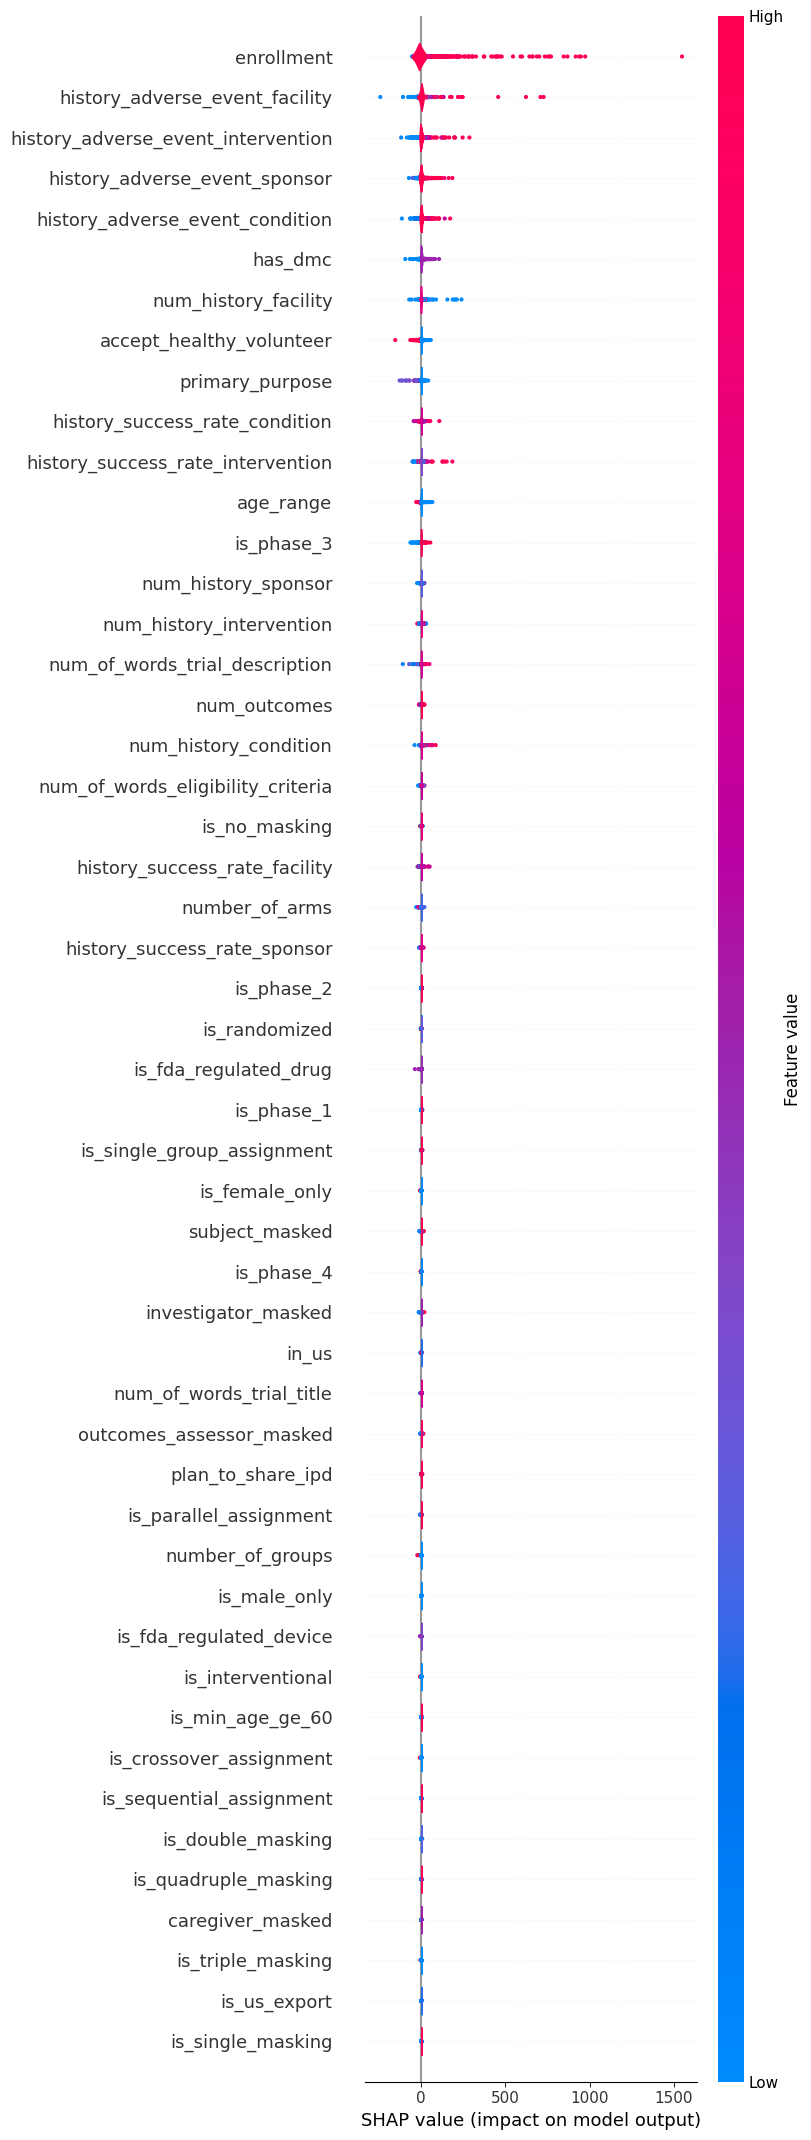

In [17]:
shap.summary_plot(shap_values, val_arr, plot_type='violin', max_display=50,
                  feature_names=feat_names)

In [18]:
task.test_table.df

,timestamp,nct_id
0,2021-01-01,248225
1,2021-01-01,227109
2,2021-01-01,179623
3,2021-01-01,223557
4,2021-01-01,198419
...,...,...
3093,2021-01-01,231588
3094,2021-01-01,137300
3095,2021-01-01,226028
3096,2021-01-01,7073


In [19]:
test_df = task.test_table.df
test_df = get_features(test_df)
test_tf = train_dset.convert_to_tensor_frame(test_df.drop(DROP_COLS, axis=1))


loading Database object from /afs/cs.stanford.edu/u/kexinh/.cache/relbench/rel-trial/db...
done in 5.26 seconds.


/tmp/user/21201/ipykernel_1869640/2423341819.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  eligibilities['minimum_age'] = eligibilities['minimum_age'].apply(lambda x: int(x.split('Years')[0]) if (x is not None) and ('Years' in x) else -1)
/tmp/user/21201/ipykernel_1869640/2423341819.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  eligibilities['maximum_age'] = eligibilities['maximum_age'].apply(lambda x: int(x.split('Years')[0]) if (x is not None) and ('Years' in x) else -1)
/tmp/user/21201/ipyk

In [20]:
pred = gbdt.predict(tf_test=test_tf)
task.evaluate(pred)

{'mae': 42.45439927072961, 'rmse': 194.14362364442943}

In [21]:
task_name = 'rel-trial-adverse'
train_df.to_csv(task_name + '-train.csv', index = False)
val_df.to_csv(task_name + '-val.csv', index = False)
test_df.to_csv(task_name + '-test.csv', index = False)

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.
